# Analyzing murA and lpxC EVcomplex runs

This notebook provides code to analyze the outputs of the initial EVcomplex runs for murA and lpxC. It does not show how the alignments were built or how the intitial models were inferred. However, the initial alignments and the trained model have been provided, and the README contains contains code to re-train the model from the alignments.

In [1]:
cd ../

/Users/sam/Documents/GitHub/evcomplex-scoring


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# "bioviper" provides easier functionality for working with Biopython classes
from bioviper import msa, pdb

# To work directly with EVcouplings DCA models
from evcouplings.couplings import CouplingsModel

from score import score_sequences

In [25]:
%matplotlib ipympl
from mpl_interactions import interactive_hist

In [4]:
init_couplings = pd.read_csv("coupling_scores/init_b0.8_CouplingScores_longrange.csv")
init_inter_couplings = init_couplings.loc[init_couplings['segment_i'] != init_couplings['segment_j']]

init_model = CouplingsModel('dca_models/murA_lpxC_b0.8_init.model')

In [37]:
murA_ali = msa.readAlignment("alignments/murA_init_align_1.a2m")
print("murA alignment has", murA_ali.N, "sequences and", murA_ali.L, 'positions')

lpxC_ali = msa.readAlignment("alignments/lpxC_init_align_2.a2m")
print("lpxC alignment has", lpxC_ali.N, "sequences and", lpxC_ali.L, 'positions')

murA_lpxC_concat_ali = msa.readAlignment("alignments/murA_lpxC_concatenated_full.a2m")
print("Concatenated alignment has", murA_lpxC_concat_ali.N, "sequences and", 
                                    murA_lpxC_concat_ali.L, 'positions')

murA alignment has 54940 sequences and 421 positions
lpxC alignment has 23634 sequences and 303 positions
Concatenated alignment has 11834 sequences and 724 positions


The murA and lpxC raw alignments are much larger than the concatenated one. For now, we'll want to trim them down to include only the sequences that end up in the concatenated alignment through the EVComplex concatenation pipeline. Note that many sequences don't make it in because either:

1) The species that the sequence is from is not present in both alignments, so there's no match to be made

2) There are two different sequences from the species in question. In this case, the one that is *most similar to the reference* was selected to be included in the concatenated alignment.

In [42]:
concat_ali_ids = murA_lpxC_concat_ali.ids[1:]

murA_sequences_in_cat_ali = [murA_ali.ids[0]] + ['_'.join(i.split('_')[:2]) for i in concat_ali_ids]
lpxC_sequences_in_cat_ali = [lpxC_ali.ids[0]] + ['_'.join(i.split('_')[2:]) for i in concat_ali_ids]

murA_ali = murA_ali.subset_by_ids(murA_sequences_in_cat_ali, sort=False).standardize()
lpxC_ali = lpxC_ali.subset_by_ids(lpxC_sequences_in_cat_ali, sort=False).standardize()

In [30]:
Scores = []; Ks = []; Kp = []

for i in range(1, 50):
    
    s, ks, kp = score_sequences(init_model, murA_ali, lpxC_ali, init_inter_couplings, i)
    Scores.append(s)

Kept 1 out of 1 pairs and 11811 out of 11834 sequences
Kept 2 out of 2 pairs and 11788 out of 11834 sequences
Kept 3 out of 3 pairs and 11752 out of 11834 sequences
Kept 4 out of 4 pairs and 11618 out of 11834 sequences
Kept 5 out of 5 pairs and 11596 out of 11834 sequences
Kept 6 out of 6 pairs and 11579 out of 11834 sequences
Kept 7 out of 7 pairs and 11538 out of 11834 sequences
Kept 8 out of 8 pairs and 11538 out of 11834 sequences
Kept 9 out of 9 pairs and 11519 out of 11834 sequences
Kept 10 out of 10 pairs and 11511 out of 11834 sequences
Kept 11 out of 11 pairs and 11509 out of 11834 sequences
Kept 12 out of 12 pairs and 10929 out of 11834 sequences
Kept 13 out of 13 pairs and 10928 out of 11834 sequences
Kept 14 out of 14 pairs and 10920 out of 11834 sequences
Kept 15 out of 15 pairs and 10918 out of 11834 sequences
Kept 16 out of 16 pairs and 10915 out of 11834 sequences
Kept 17 out of 17 pairs and 10915 out of 11834 sequences
Kept 18 out of 18 pairs and 10915 out of 11834 se

Text(0.5, 1.0, "Interaction scores for the top N 'true positive' couplings")

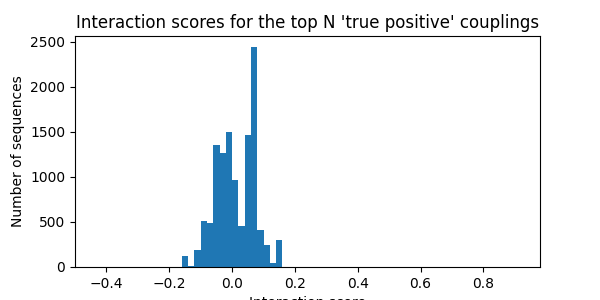

In [31]:
def scores_indexer(n):
    return np.sum(Scores[n],axis=1)

fig, ax = plt.subplots(figsize=(6,3))
controls = interactive_hist(scores_indexer, n=np.arange(1,48,1), bins=np.arange(-0.5, 1, 0.02))

plt.xlabel("Interaction score")
plt.ylabel("Number of sequences")

plt.title("Interaction scores for the top N 'true positive' couplings")

In [9]:
murA_ali.structures  = {}; lpxC_ali.structures = {}
murA_ali.attach_structure('structures/Paeruginosa_lpxC_murA_AF_ranked_1.pdb', 0)
lpxC_ali.attach_structure('structures/Paeruginosa_lpxC_murA_AF_ranked_1.pdb', 0)

In [10]:
complex_structure = pdb.readPDB("structures/Paeruginosa_lpxC_murA_AF_ranked_1.pdb")

In [11]:
inter_distances = []; first_index = 1

murA_structure_pos = murA_ali.structures[0][-1]._pdbpos
lpxC_structure_pos = lpxC_ali.structures[0][-1]._pdbpos

murA_ali_pos = list(murA_ali.structures[0][-1]._alipos)
lpxC_ali_pos = list(lpxC_ali.structures[0][-1]._alipos)

for nrow,row in init_inter_couplings.iterrows():
    try:
        pdb_i = murA_structure_pos[murA_ali_pos.index(row["i"])] - first_index
        pdb_j = lpxC_structure_pos[lpxC_ali_pos.index(row["j"])] - first_index
        
        inter_distances.append(complex_structure.distance_matrix()[pdb_i, pdb_j])
    except:
        #print(row["i"], row["j"])
        inter_distances.append(np.nan)
        
inter_distances = np.array(inter_distances)

init_inter_couplings = init_inter_couplings.assign(distance=inter_distances)

In [12]:
plt.xlim(0.032,0.07)
plt.scatter(init_inter_couplings['cn'], init_inter_couplings['distance'])

contacts = init_inter_couplings['distance'] < 9

plt.scatter(init_inter_couplings['cn'][contacts], init_inter_couplings['distance'][contacts])

plt.axhline(y=8, c='k', linestyle='dashed')

plt.xlabel("Coupling score (cn)")
plt.ylabel("CA-CA distance")

Text(24.597222222222214, 0.5, 'CA-CA distance')

In [13]:
true_positive_hits = np.where(init_inter_couplings['distance'] < 9)[0]

In [29]:
tp_Scores = []; Ks = []; Kp = []

for i in range(1, 20):
    
    s, ks, kp = score_sequences(init_model, murA_ali, lpxC_ali, init_inter_couplings, true_positive_hits[:i])
    tp_Scores.append(s)

Kept 1 out of 1 pairs and 11782 out of 11834 sequences
Kept 2 out of 2 pairs and 11663 out of 11834 sequences
Kept 3 out of 3 pairs and 11660 out of 11834 sequences
Kept 4 out of 4 pairs and 11659 out of 11834 sequences
Kept 5 out of 5 pairs and 11031 out of 11834 sequences
Kept 5 out of 6 pairs and 11031 out of 11834 sequences
Kept 6 out of 7 pairs and 11028 out of 11834 sequences
Kept 7 out of 8 pairs and 11021 out of 11834 sequences
Kept 8 out of 9 pairs and 11002 out of 11834 sequences
Kept 9 out of 10 pairs and 11001 out of 11834 sequences
Kept 9 out of 11 pairs and 11001 out of 11834 sequences
Kept 9 out of 12 pairs and 11001 out of 11834 sequences
Kept 10 out of 13 pairs and 11001 out of 11834 sequences
Kept 10 out of 14 pairs and 11001 out of 11834 sequences
Kept 11 out of 15 pairs and 11001 out of 11834 sequences
Kept 11 out of 16 pairs and 11001 out of 11834 sequences
Kept 12 out of 17 pairs and 11001 out of 11834 sequences
Kept 13 out of 18 pairs and 10958 out of 11834 seque

Text(0.5, 1.0, "Interaction scores for the top N 'true positive' couplings")

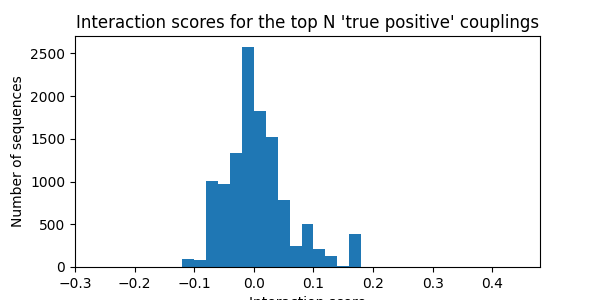

In [23]:
%matplotlib ipympl

def f(n):
    return np.sum(S[n],axis=1)

fig, ax = plt.subplots(figsize=(6,3))
controls = interactive_hist(f, n=np.arange(1,19,1), bins=np.arange(-0.3, 0.5, 0.02))

plt.xlabel("Interaction score")
plt.ylabel("Number of sequences")

plt.title("Interaction scores for the top N 'true positive' couplings")

In [45]:
scores_tp5, keep_s_tp5, keep_p_tp5 = score_sequences(init_model, 
                                                     murA_ali,
                                                     lpxC_ali, 
                                                     init_inter_couplings, 
                                                     true_positive_hits[:5])

Kept 5 out of 5 pairs and 11031 out of 11834 sequences


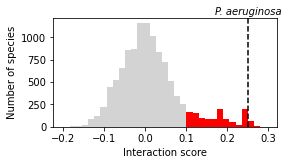

In [33]:
%matplotlib inline

plt.figure(figsize=(4,2))
plt.rcParams['pdf.fonttype'] = 'truetype'

sum_s = np.sum(tp_Scores[4],axis=1)

plt.hist(sum_s, bins=np.arange(-0.2,0.3,0.015), color='lightgray')
plt.hist(sum_s[sum_s>0.1], bins=np.arange(0.1,0.3,0.015), color='red')

#plt.axvline(0.1, c='k', ls='dashed', lw=2)

plt.axvline(sum_s[0], c='k', ls="dashed")
plt.text(0.17, 1250, "P. aeruginosa", fontstyle='italic')

plt.xlabel("Interaction score")
plt.ylabel("Number of species")

plt.savefig("interaction_score_histogram_v1.pdf", bbox_inches="tight")

Now I will actually select these sequences to make new alignments (and annotation files)

In [58]:
positive_sequences = np.sum(tp_Scores[4], axis=1) > 0.1

print("Selected positive sequences:", np.sum(positive_sequences), '/', len(positive_sequences))

# Note that a few pairs were 'discarded' during the scoring because they had too many gaps
#  therefore I first have to index only with the ones that were able to be scored at all ("keep_s_tp5"),
#  and then after that index with positive_sequences which tells me which AMONG THOSE has s > 0.1
murA_ali_new = murA_ali[keep_s_tp5][positive_sequences]
lpxC_ali_new = lpxC_ali[keep_s_tp5][positive_sequences]

Selected positive sequences: 1219 / 11031


In [51]:
murA_annotation = pd.read_csv('annotation/murA_annotation.csv', index_col='id')
lpxC_annotation = pd.read_csv('annotation/lpxC_annotation.csv', index_col='id')

In [55]:
murA_annotation.loc[murA_ali_new.ids].to_csv('annotation/murA_tp5_pred_annotation.csv')
lpxC_annotation.loc[lpxC_ali_new.ids].to_csv('annotation/lpxC_tp5_pred_annotation.csv')

murA_ali_new.save("alignments/murA_tp5_pred.fa")
lpxC_ali_new.save("alignments/lpxC_tp5_pred.fa")